In [2]:
import os
import numpy as np
import pandas as pd
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import lightning as L

import matplotlib.pyplot as plt
import seaborn as sns

import torchvision
from lightning.pytorch.callbacks import ModelCheckpoint
from tqdm.notebook import tqdm
from torchvision.datasets import CIFAR100

In [3]:
%reload_ext watermark
%watermark -a "Rodrigo W Pisaia" --iversions --python

torch.cuda.empty_cache()

Author: Rodrigo W Pisaia

Python implementation: CPython
Python version       : 3.10.14
IPython version      : 8.20.0

seaborn    : 0.12.2
numpy      : 1.26.3
torchvision: 0.18.0+cu121
torch      : 2.3.0+cu121
lightning  : 2.0.9.post0
matplotlib : 3.8.4
pandas     : 2.2.1



$\alpha_i = \frac{\exp\left(f_{attn}\left(\text{key}_i, \text{query}\right)\right)}{\sum_j \exp\left(f_{attn}\left(\text{key}_j, \text{query}\right)\right)}, \hspace{5mm} \text{out} = \sum_i \alpha_i \cdot \text{value}_i$

In [3]:
def scaled_dot_product(q, k, v, mask=None):
    """Calculate scaled dot product attention.

    This function calculates the scaled dot product attention between query (q), key (k), and value (v) tensors.
    It applies a mask to the attention logits if provided.

    Args:
        q (torch.Tensor): The query tensor of shape (batch_size, seq_len_q, d_k).
        k (torch.Tensor): The key tensor of shape (batch_size, seq_len_k, d_k).
        v (torch.Tensor): The value tensor of shape (batch_size, seq_len_v, d_v).
        mask (torch.Tensor, optional): The mask tensor of shape (batch_size, seq_len_q, seq_len_k).
            Defaults to None.

    Returns:
        torch.Tensor: The output values tensor of shape (batch_size, seq_len_q, d_v).
        torch.Tensor: The attention tensor of shape (batch_size, seq_len_q, seq_len_k).
    """
    d_k = q.size()[-1]  # lentght of vector
    attn_logits = torch.matmul(
        q, k.transpose(-2, -1)
    )  # transpose matrix, equivalent to torch.Tensor().transpose(0, 1)
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = F.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [4]:
seq_len, d_k = 3, 2
L.seed_everything(42)
q = torch.randn(seq_len, d_k)
k = torch.randn(seq_len, d_k)
v = torch.randn(seq_len, d_k)
values, attention = scaled_dot_product(q, k, v)
print("Q\n", q)
print("K\n", k)
print("V\n", v)
print("Values\n", values)
print("Attention\n", attention)

Global seed set to 42


Q
 tensor([[ 0.3367,  0.1288],
        [ 0.2345,  0.2303],
        [-1.1229, -0.1863]])
K
 tensor([[ 2.2082, -0.6380],
        [ 0.4617,  0.2674],
        [ 0.5349,  0.8094]])
V
 tensor([[ 1.1103, -1.6898],
        [-0.9890,  0.9580],
        [ 1.3221,  0.8172]])
Values
 tensor([[ 0.5698, -0.1520],
        [ 0.5379, -0.0265],
        [ 0.2246,  0.5556]])
Attention
 tensor([[0.4028, 0.2886, 0.3086],
        [0.3538, 0.3069, 0.3393],
        [0.1303, 0.4630, 0.4067]])


### Multi-Head Attention

The scaled dot product attention allows a network to attend over a sequence.
However, often there are multiple different aspects a sequence element wants to attend to,
and a single weighted average is not a good option for it.
This is why we extend the attention mechanisms to multiple heads,
i.e. multiple different query-key-value triplets on the same features.
Specifically, given a query, key, and value matrix, we transform those into $h$ sub-queries, sub-keys,
and sub-values, which we pass through the scaled dot product attention independently.
Afterward, we concatenate the heads and combine them with a final weight matrix.
Mathematically, we can express this operation as:

$$
\begin{split}
    \text{Multihead}(Q,K,V) & = \text{Concat}(\text{head}_1,...,\text{head}_h)W^{O}\\
    \text{where } \text{head}_i & = \text{Attention}(QW_i^Q,KW_i^K, VW_i^V)
\end{split}
$$

We refer to this as Multi-Head Attention layer with the learnable parameters
$W_{1...h}^{Q}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{K}\in\mathbb{R}^{D\times d_k}$,
$W_{1...h}^{V}\in\mathbb{R}^{D\times d_v}$,
and $W^{O}\in\mathbb{R}^{h\cdot d_k\times d_{out}}$ ($D$ being the input dimensionality).
Expressed in a computational graph, we can visualize it as below
(figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/multihead_attention.svg" width="230px"></center>

How are we applying a Multi-Head Attention layer in a neural network,
where we don't have an arbitrary query, key, and value vector as input?
Looking at the computation graph above, a simple but effective implementation is to set the current
feature map in a NN, $X\in\mathbb{R}^{B\times T\times d_{\text{model}}}$, as $Q$, $K$ and $V$
($B$ being the batch size, $T$ the sequence length, $d_{\text{model}}$ the hidden dimensionality of $X$).
The consecutive weight matrices $W^{Q}$, $W^{K}$, and $W^{V}$ can transform $X$ to the corresponding
feature vectors that represent the queries, keys, and values of the input.
Using this approach, we can implement the Multi-Head Attention module below.

In [5]:
class MultiHeadAttention(nn.Module):
    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()

        assert (
            embed_dim % num_heads == 0
        ), "Embedding dimension must be divisible by number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        self.qkv_proj = nn.Linear(input_dim, 3 * self.embed_dim)
        self.o_proj = nn.Linear(self.embed_dim, self.embed_dim)

        self._reset_parameters()  # reset bias parameters and initialize the weights using xavier_uniform

    def _reset_parameters(self):
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3 * self.head_dim)
        qkv = qkv.permuite(0, 2, 1, 3)  # [Batch, Head, SeqLen, HeadDims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outpouts
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3)
        values = values.reshape(batch_size, seq_length, self.embed_dim)
        o = self.o_proj(values)

        if return_attention == True:
            return o, attention
        else:
            return o

## Transformer Encoder

### Transformer Encoder
Next, we will look at how to apply the multi-head attention blog inside the Transformer architecture.
Originally, the Transformer model was designed for machine translation.
Hence, it got an encoder-decoder structure where the encoder takes as input the sentence in the original language
and generates an attention-based representation.
On the other hand, the decoder attends over the encoded information and generates the translated sentence
in an autoregressive manner, as in a standard RNN.
While this structure is extremely useful for Sequence-to-Sequence tasks with the necessity of autoregressive decoding,
we will focus here on the encoder part.
Many advances in NLP have been made using pure encoder-based Transformer models (if interested, models include the
[BERT](https://arxiv.org/abs/1810.04805)-family,
the [Vision Transformer](https://arxiv.org/abs/2010.11929), and more),
and in our tutorial, we will also mainly focus on the encoder part.
If you have understood the encoder architecture, the decoder is a very small step to implement as well.
The full Transformer architecture looks as follows
(figure credit - [Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).
:

<center width="100%"><img src="https://github.com/Lightning-AI/lightning-tutorials/raw/main/course_UvA-DL/05-transformers-and-MH-attention/transformer_architecture.svg" width="400px"></center>

The encoder consists of $N$ identical blocks that are applied in sequence.
Taking as input $x$, it is first passed through a Multi-Head Attention block as we have implemented above.
The output is added to the original input using a residual connection,
and we apply a consecutive Layer Normalization on the sum.
Overall, it calculates $\text{LayerNorm}(x+\text{Multihead}(x,x,x))$
($x$ being $Q$, $K$ and $V$ input to the attention layer).
The residual connection is crucial in the Transformer architecture for two reasons:

>1.
Similar to ResNets, Transformers are designed to be very deep.
Some models contain more than 24 blocks in the encoder.
Hence, the residual connections are crucial for enabling a smooth gradient flow through the model.
>2.
Without the residual connection, the information about the original sequence is lost.
Remember that the Multi-Head Attention layer ignores the position of elements in a sequence,
and can only learn it based on the input features.
Removing the residual connections would mean that this information is lost after the first attention layer
(after initialization), and with a randomly initialized query and key vector,
the output vectors for position $i$ has no relation to its original input.
All outputs of the attention are likely to represent similar/same information,
and there is no chance for the model to distinguish which information came from which input element.
An alternative option to residual connection would be to fix at least one head to focus on its original input,
but this is very inefficient and does not have the benefit of the improved gradient flow.

The Layer Normalization also plays an important role in the Transformer architecture as it enables faster
training and provides small regularization.
Additionally, it ensures that the features are in a similar magnitude among the elements in the sequence.
We are not using Batch Normalization because it depends on the batch size which is often small with Transformers
(they require a lot of GPU memory), and BatchNorm has shown to perform particularly bad in language
as the features of words tend to have a much higher variance (there are many, very rare words
which need to be considered for a good distribution estimate).

Additionally to the Multi-Head Attention, a small fully connected feed-forward network is added to the model,
which is applied to each position separately and identically.
Specifically, the model uses a Linear$\to$ReLU$\to$Linear MLP.
The full transformation including the residual connection can be expressed as:

$$
\begin{split}
    \text{FFN}(x) & = \max(0, xW_1+b_1)W_2 + b_2\\
    x & = \text{LayerNorm}(x + \text{FFN}(x))
\end{split}
$$

This MLP adds extra complexity to the model and allows transformations on each sequence element separately.
You can imagine as this allows the model to "post-process" the new information added
by the previous Multi-Head Attention, and prepare it for the next attention block.
Usually, the inner dimensionality of the MLP is 2-8$\times$ larger than $d_{\text{model}}$,
i.e. the dimensionality of the original input $x$.
The general advantage of a wider layer instead of a narrow, multi-layer MLP is the faster, parallelizable execution.

Finally, after looking at all parts of the encoder architecture, we can start implementing it below.
We first start by implementing a single encoder block.
Additionally to the layers described above, we will add dropout layers in the MLP and on the output
of the MLP and Multi-Head Attention for regularization.

In [6]:
class EncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, dim_feedfoward, dropout: float = 0.0):
        super().__init__()

        # attention Layer
        self.self_attn = MultiHeadAttention(input_dim, input_dim, num_heads)

        # two layer mlp
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedfoward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedfoward, input_dim),
        )

        self.norm1 = nn.LayerNorm(input_dim)  # z-score normalization
        self.norm2 = nn.LayerNorm(input_dim)  # z-score normalization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)  # skip connection + dropout
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)  # skip connection + dropout
        x = self.norm2(x)
        return x

In [7]:
class TransformerEncoder(nn.Module):
    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList(
            [EncoderBlock(**block_args) for _ in range(num_layers)]
        )

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for layer in self.layers:
            x, attention = layer(x, mask=mask, return_attention=True)
            attention_maps.append(attention)
        return attention_maps

### Positional encoding

We have discussed before that the Multi-Head Attention block is permutation-equivariant,
and cannot distinguish whether an input comes before another one in the sequence or not.
In tasks like language understanding, however, the position is important for interpreting the input words.
The position information can therefore be added via the input features.
We could learn a embedding for every possible position, but this would not generalize to a dynamical
input sequence length.
Hence, the better option is to use feature patterns that the network can identify from the features
and potentially generalize to larger sequences.
The specific pattern chosen by Vaswani et al.
are sine and cosine functions of different frequencies, as follows:

$$
PE_{(pos,i)} = \begin{cases}
    \sin\left(\frac{pos}{10000^{i/d_{\text{model}}}}\right) & \text{if}\hspace{3mm} i \text{ mod } 2=0\\
    \cos\left(\frac{pos}{10000^{(i-1)/d_{\text{model}}}}\right) & \text{otherwise}\\
\end{cases}
$$

$PE_{(pos,i)}$ represents the position encoding at position $pos$ in the sequence, and hidden dimensionality $i$.
These values, concatenated for all hidden dimensions, are added to the original input features
(in the Transformer visualization above, see "Positional encoding"), and constitute the position information.
We distinguish between even ($i \text{ mod } 2=0$) and uneven ($i \text{ mod } 2=1$)
hidden dimensionalities where we apply a sine/cosine respectively.
The intuition behind this encoding is that you can represent $PE_{(pos+k,:)}$ as a linear function
of $PE_{(pos,:)}$, which might allow the model to easily attend to relative positions.
The wavelengths in different dimensions range from $2\pi$ to $10000\cdot 2\pi$.

The positional encoding is implemented below.
The code is taken from the [PyTorch tutorial](https://pytorch.org/tutorials/beginner/transformer_tutorial.html#define-the-model)
about Transformers on NLP and adjusted for our purposes.

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        # create matrix of [SeqLen, HiddeDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)
        )
        print(div_term)

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer("pe", pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)]
        return x

tensor([1.0000e+00, 6.8129e-01, 4.6416e-01, 3.1623e-01, 2.1544e-01, 1.4678e-01,
        1.0000e-01, 6.8129e-02, 4.6416e-02, 3.1623e-02, 2.1544e-02, 1.4678e-02,
        1.0000e-02, 6.8129e-03, 4.6416e-03, 3.1623e-03, 2.1544e-03, 1.4678e-03,
        1.0000e-03, 6.8129e-04, 4.6416e-04, 3.1623e-04, 2.1544e-04, 1.4678e-04])


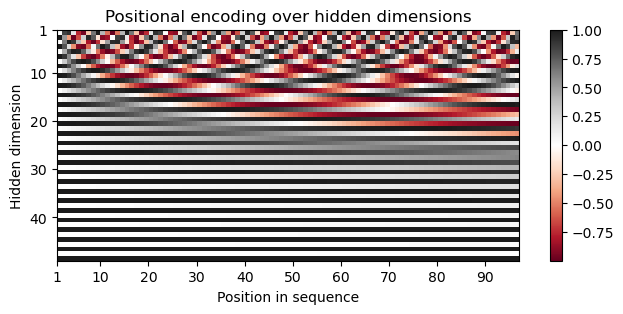

In [9]:
encod_block = PositionalEncoding(d_model=48, max_len=96)
pe = encod_block.pe.squeeze().T.cpu().numpy()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,3))
pos = ax.imshow(pe, cmap="RdGy", extent=(1,pe.shape[1]+1,pe.shape[0]+1,1))
fig.colorbar(pos, ax=ax)
ax.set_xlabel("Position in sequence")
ax.set_ylabel("Hidden dimension")
ax.set_title("Positional encoding over hidden dimensions")
ax.set_xticks([1]+[i*10 for i in range(1,1+pe.shape[1]//10)])
ax.set_yticks([1]+[i*10 for i in range(1,1+pe.shape[0]//10)])
plt.show()

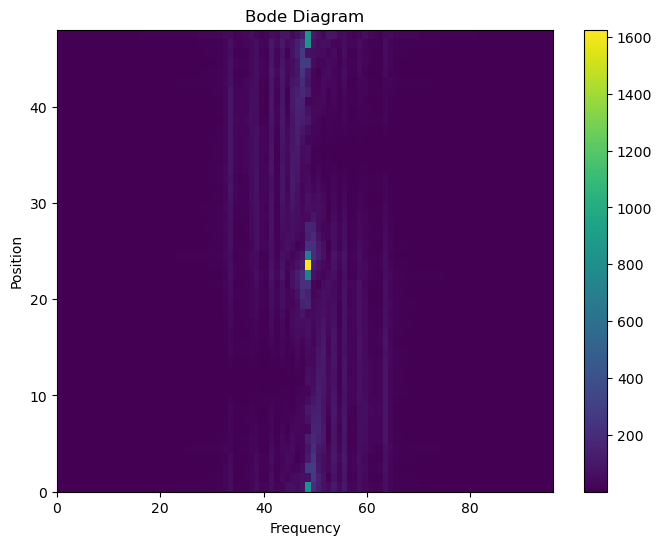

In [10]:
# plotting in frequency domain
pe_fft = np.fft.fft2(pe)
pe_fft = np.fft.fftshift(pe_fft)
pe_fft = np.abs(pe_fft)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.imshow(pe_fft, aspect='auto', extent=[0, pe_fft.shape[1], 0, pe_fft.shape[0]])
plt.colorbar()
plt.title('Bode Diagram')
plt.xlabel('Frequency')
plt.ylabel('Position')
plt.show()

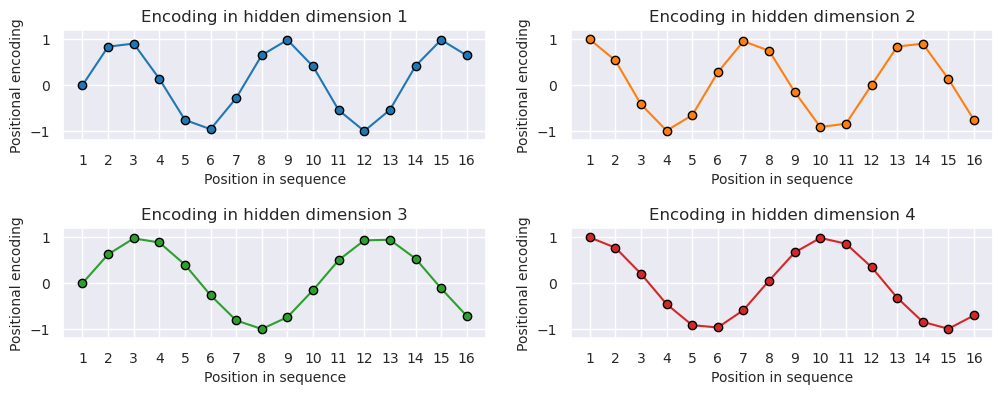

In [11]:
sns.set_theme()
fig, ax = plt.subplots(2, 2, figsize=(12,4))
ax = [a for a_list in ax for a in a_list]
for i in range(len(ax)):
    ax[i].plot(np.arange(1,17), pe[i,:16], color=f'C{i}', marker="o", markersize=6, markeredgecolor="black")
    ax[i].set_title(f"Encoding in hidden dimension {i+1}")
    ax[i].set_xlabel("Position in sequence", fontsize=10)
    ax[i].set_ylabel("Positional encoding", fontsize=10)
    ax[i].set_xticks(np.arange(1,17))
    ax[i].tick_params(axis='both', which='major', labelsize=10)
    ax[i].tick_params(axis='both', which='minor', labelsize=8)
    ax[i].set_ylim(-1.2, 1.2)
fig.subplots_adjust(hspace=0.8)
sns.reset_orig()
plt.show()

In [17]:
class CosineWarmupScheduler(torch.optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

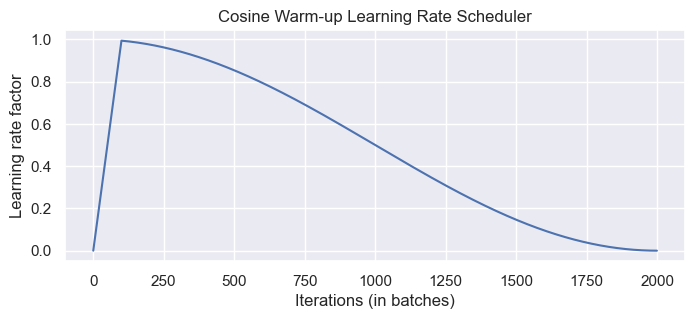

In [18]:
# Needed for initializing the lr scheduler
p = nn.Parameter(torch.empty(4, 4))
optimizer = torch.optim.Adam([p], lr=1e-3)
lr_scheduler = CosineWarmupScheduler(optimizer=optimizer, warmup=100, max_iters=2000)

# Plotting
epochs = list(range(2000))
sns.set()
plt.figure(figsize=(8, 3))
plt.plot(epochs, [lr_scheduler.get_lr_factor(e) for e in epochs])
plt.ylabel("Learning rate factor")
plt.xlabel("Iterations (in batches)")
plt.title("Cosine Warm-up Learning Rate Scheduler")
plt.show()
sns.reset_orig()

# Model Lightning

In [20]:
class TransformerPredictor(L.LightningModule):
    def __init__(
        self,
        input_dim,
        model_dim,
        num_classes,
        num_heads,
        num_layers,
        lr,
        warmup,
        max_iters,
        dropout=0.0,
        input_dropout=0.0,
    ):
        super().__init__()
        self.save_hyperparameters()
        self._create_model()

    def _create_model(self):
        self.input_net = nn.Sequential(
            nn.Dropout(self.hparams.input_dropout),
            nn.Linear(self.hparams.input_dim, self.hparams.model_dim),
        )

        self.positional_encoding = PositionalEncoding(d_model=self.hparams.model_dim)
        self.transformer = TransformerEncoder(
            num_layers=self.hparams.num_layers,
            input_dim=self.hparams.model_dim,
            dim_feedforward=2 * self.hparams.model_dim,
            num_heads=self.hparams.num_heads,
            dropout=self.hparams.dropout,
        )

        self.output_net = nn.Sequential(
            nn.Linear(self.hparams.model_dim, self.hparams.model_dim),
            nn.LayerNorm(self.hparams.model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(self.hparams.dropout),
            nn.Linear(self.hparams.model_dim, self.hparams.num_classes),
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
        return x

    @torch.no_grad()
    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):

        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        lr_scheduler = CosineWarmupScheduler(
            optimizer, self.hparams.warmup, self.hparams.max_iters
        )
        return [optimizer], [{"scheduler": lr_scheduler, "interval": "step"}]

    def training_step(self, batch, batch_idx):
        raise NotImplementedError

    def validation_step(self, batch, batch_idx):
        raise NotImplementedError

    def test_step(self, batch, batch_idx):
        raise NotImplementedError